In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from warnings import simplefilter # disable tensorflow warnings
simplefilter(action='ignore', category=FutureWarning)

import h5py
import imageio
import ipdb
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial.transform import Rotation as R
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook  

import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
from robonet.robonet.datasets.util.hdf5_loader import (default_loader_hparams,
                                                       load_actions,
                                                       load_camera_imgs,
                                                       load_states, load_qpos)
from robonet.robonet.datasets.util.metadata_helper import load_metadata
from src.env.robotics.masks.baxter_mask_env import BaxterMaskEnv
from src.env.robotics.masks.sawyer_mask_env import SawyerMaskEnv
from src.env.robotics.masks.widowx_mask_env import WidowXMaskEnv
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

robonet_root = "/media/ed/hdd/Datasets/Robonet/hdf5/"
metadata_path = "/media/ed/hdd/Datasets/Robonet/hdf5/meta_data.pkl"

could not import trainables!


In [3]:
def load_all_states(hdf5_list):
    all_states = []
    prev_ws_min = prev_ws_max = None
    
    for traj_name in tqdm(hdf5_list, f"Collecting states"):
        file_metadata = df.loc[traj_name]
        ws_min = file_metadata["low_bound"]
        ws_max = file_metadata["high_bound"]
        if prev_ws_min is None:
            prev_ws_min = ws_min
            prev_ws_max = ws_max
        ws_min_close = np.allclose(prev_ws_min, ws_min)
        ws_max_close = np.allclose(prev_ws_max, ws_max)
        if not (ws_min_close and ws_max_close):
            print(traj_name, "ws not same")
            print(ws_min, prev_ws_min)
            print(ws_max, prev_ws_max)
        prev_ws_min = ws_min
        prev_ws_max = ws_max
        
        
        f_name = os.path.join(robonet_root, traj_name)

        with h5py.File(f_name, "r") as hf:
            start_time, n_states = 0, min([file_metadata['state_T'], file_metadata['img_T'], file_metadata['action_T'] + 1])
            states = load_states(hf, file_metadata, hparams)
            assert states.shape[-1] == 5
            all_states.append(states)
    return np.asarray(all_states), ws_min, ws_max

In [10]:
# first load widowx states
hparams = tf.contrib.training.HParams(**default_loader_hparams())
hparams.img_size = [120, 160]
hparams.cams_to_load = [0]
hparams.target_adim = 5

df = pd.read_pickle(metadata_path, compression="gzip")
widowx_df = df.loc["widowx" == df["robot"]]

widowx_subset = widowx_df[widowx_df["camera_configuration"] == "widowx1"].sample(100)
# widowx_states, widowx_min, widowx_max = load_all_states(widowx_subset.index)

# sawyer_df = df.loc["sawyer" == df["robot"]]
# sawyer_subset = sawyer_df[("sudri2" == sawyer_df["camera_configuration"]) & ("none" == sawyer_df["primitives"])].sample(100)
# sawyer_states, sawyer_min, sawyer_max = load_all_states(sawyer_subset.index)

# baxter_df = df.loc["baxter" == df["robot"]]
# left = ["left" in x for x in baxter_df.index]
# right = [not x for x in left]
# baxter_left_subset = baxter_df[left].sample(100)
# baxter_right_subset = baxter_df[right].sample(100)
# baxter_left_states, baxter_left_min, baxter_left_max = load_all_states(baxter_left_subset.index)
# baxter_right_states, baxter_right_min, baxter_right_max = load_all_states(baxter_right_subset.index)

In [13]:
widowx_df["camera_configuration"].value_counts()

widowx1    1468
widowx4    1188
widowx0    1185
widowx3     959
widowx2     250
Name: camera_configuration, dtype: int64

In [4]:
robot_data = {"baxter_left": baxter_left_states, "baxter_right": baxter_right_states, "sawyer": sawyer_states, "widowx": widowx_states}
robot_min = {"baxter_left": baxter_left_min, "baxter_right": baxter_right_min, "sawyer": sawyer_min, "widowx": widowx_min}
robot_max = {"baxter_left": baxter_left_max, "baxter_right": baxter_right_max, "sawyer": sawyer_max, "widowx": widowx_max}


# Rotation bounds
They are stored in raw radians. I don't think I need to normalize the gripper rotations since they are all in radians already.

Seems like gripper rotations need to be normalized with radians. Baxter's gripper rotation bounds are in degree
 

Examining rotation
baxter_left Raw Data stats


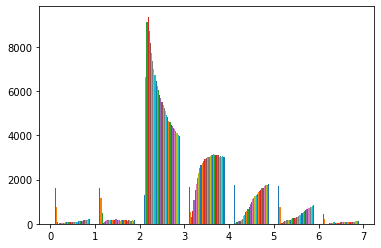

min 0.00 max 6.28 mean 3.06
baxter_right Raw Data stats


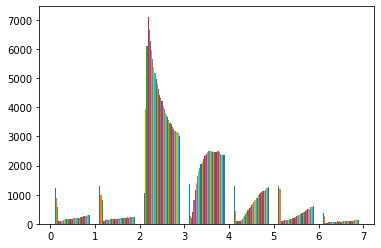

min 0.00 max 6.28 mean 3.02
sawyer Raw Data stats


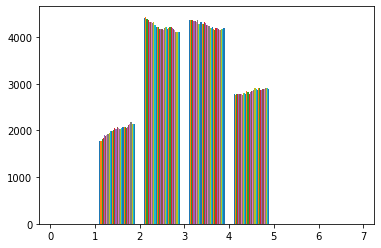

min 1.50 max 4.68 mean 3.10
widowx Raw Data stats


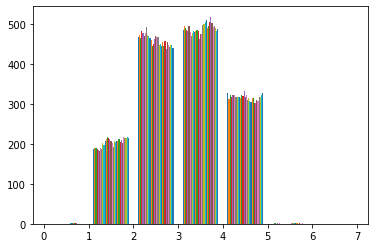

min 0.42 max 5.23 mean 3.14


In [76]:
# examine gripper rotation for each robot
print("Examining rotation")
# fig, axes = plt.subplots(1, len(robot_data.keys()))
for robot, states in robot_data.items(): 
    gripper_rotation = states[:,:, 3]
    print(f"{robot} Raw Data stats")
    plt.hist(gripper_rotation, bins=[0,1,2,3,4,5,6,7])
    plt.show()
    print(f"min {gripper_rotation.min():.2f}", f"max {gripper_rotation.max():.2f}", f"mean {gripper_rotation.mean():.2f}")
#     rmin = robot_min[robot][3]
#     rmax = robot_max[robot][3]
#     if "baxter" in robot:
#         # convert to radians
#         rmin *= np.pi/180
#         rmax *= np.pi/180
#     print("rotation min, rotation max", rmin, rmax)
#     print(f"After Normalization stats")
#     gripper_rotation_norm = (states[:,:, 3] -  rmin) / (rmax - rmin)
#     print(f"min {gripper_rotation_norm.min():.2f}", f"max {gripper_rotation_norm.max():.2f}", f"mean {gripper_rotation_norm.mean():.2f}")
# #     print(f"After Denormalization stats")
# #     gripper_rotation_norm = (states[:,:, 3] * (rmax - rmin)) + rmin
# #     print(f"min {gripper_rotation_norm.min():.2f}", f"max {gripper_rotation_norm.max():.2f}", f"mean {gripper_rotation_norm.mean():.2f}")
#     print()



# Force Bounds
Stored in raw gripper qpos, needs to be normalized to[0,1)

Examining force
baxter_left Raw Data stats
min 1.77 max 100.00 mean 48.67
rotation min, rotation max 0.0 100.0
After Normalization stats
min 0.02 max 1.00 mean 0.49



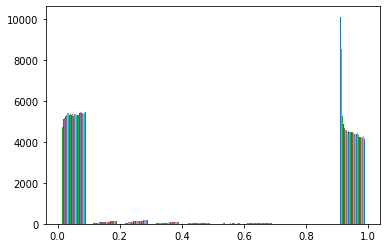

baxter_right Raw Data stats
min 2.92 max 100.00 mean 50.28
rotation min, rotation max 0.0 100.0
After Normalization stats
min 0.03 max 1.00 mean 0.50



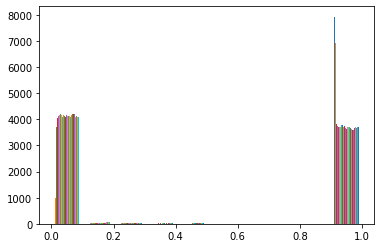

sawyer Raw Data stats
min -1.01 max 1.02 mean -0.01
rotation min, rotation max -1.0 1.0
After Normalization stats
min -0.00 max 1.01 mean 0.49



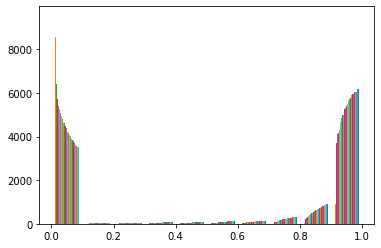

widowx Raw Data stats
min -1.01 max 1.01 mean 0.29
rotation min, rotation max -1.0 1.0
After Normalization stats
min -0.01 max 1.00 mean 0.65



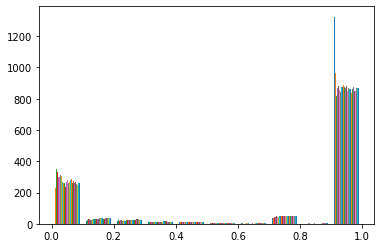

In [78]:
# examine gripper force for each robot
print("Examining force")
for robot, states in robot_data.items(): 
    gripper_rotation = states[:,:, 4]
    print(f"{robot} Raw Data stats")
    print(f"min {gripper_rotation.min():.2f}", f"max {gripper_rotation.max():.2f}", f"mean {gripper_rotation.mean():.2f}")
    rmin = robot_min[robot][4]
    rmax = robot_max[robot][4]
#     if "baxter" in robot:
#         # convert to radians
#         rmin *= np.pi/180
#         rmax *= np.pi/180
    print("rotation min, rotation max", rmin, rmax)
    print(f"After Normalization stats")
    gripper_rotation_norm = (states[:,:, 4] -  rmin) / (rmax - rmin)
    print(f"min {gripper_rotation_norm.min():.2f}", f"max {gripper_rotation_norm.max():.2f}", f"mean {gripper_rotation_norm.mean():.2f}")
#     print(f"After Denormalization stats")
#     gripper_rotation_norm = (states[:,:, 3] * (rmax - rmin)) + rmin
#     print(f"min {gripper_rotation_norm.min():.2f}", f"max {gripper_rotation_norm.max():.2f}", f"mean {gripper_rotation_norm.mean():.2f}")
    print()
    plt.hist(gripper_rotation_norm, bins=[0.1 * x for x in range(0, 11)])
    plt.show()

# XYZ Bounds
Let's double check that the XYZ positions are normalized per robot already.

Examining X
baxter_left Raw Data stats


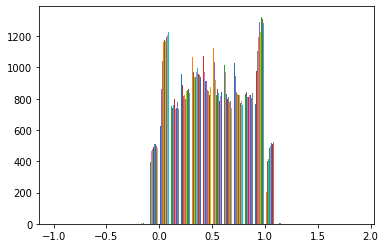

min -0.20 max 1.16 mean 0.50
rotation min, rotation max 0.15 0.59

baxter_right Raw Data stats


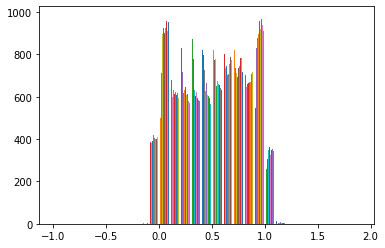

min -0.19 max 1.20 mean 0.51
rotation min, rotation max -0.63 -0.2

sawyer Raw Data stats


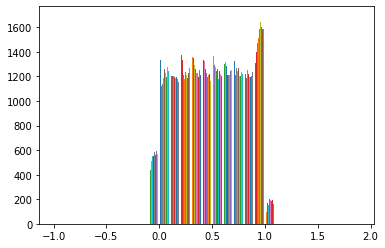

min -0.03 max 1.02 mean 0.50
rotation min, rotation max -0.18 0.22

widowx Raw Data stats


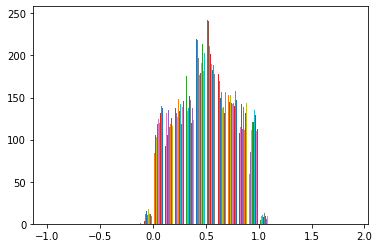

min -0.12 max 1.07 mean 0.50
rotation min, rotation max -0.13 0.13



In [95]:
# examine X  for each robot
print("Examining X")
# fig, axes = plt.subplots(1, len(robot_data.keys()))
for robot, states in robot_data.items(): 
    axis = 1
    gripper_rotation = states[:,:, axis]
    print(f"{robot} Raw Data stats")
    plt.hist(gripper_rotation, bins=[0.1 * x for x in range(-10, 20)])
    plt.show()
    print(f"min {gripper_rotation.min():.2f}", f"max {gripper_rotation.max():.2f}", f"mean {gripper_rotation.mean():.2f}")
    rmin = robot_min[robot][axis]
    rmax = robot_max[robot][axis]
#     if "baxter" in robot:
        # convert to radians
#         rmin *= np.pi/180
#         rmax *= np.pi/180
    print("rotation min, rotation max", rmin, rmax)
#     print(f"After Normalization stats")
#     gripper_rotation_norm = (states[:,:, 3] -  rmin) / (rmax - rmin)
#     print(f"min {gripper_rotation_norm.min():.2f}", f"max {gripper_rotation_norm.max():.2f}", f"mean {gripper_rotation_norm.mean():.2f}")
# #     print(f"After Denormalization stats")
# #     gripper_rotation_norm = (states[:,:, 3] * (rmax - rmin)) + rmin
# #     print(f"min {gripper_rotation_norm.min():.2f}", f"max {gripper_rotation_norm.max():.2f}", f"mean {gripper_rotation_norm.mean():.2f}")
    print()



# Action Bounds

In [6]:
def load_all_actions(hdf5_list):
    all_actions = []
    
    for traj_name in tqdm(hdf5_list, f"Collecting actions"):
        file_metadata = df.loc[traj_name]
        
        f_name = os.path.join(robonet_root, traj_name)

        with h5py.File(f_name, "r") as hf:
            actions = load_actions(hf, file_metadata, hparams)
            assert actions.shape[-1] == 5, actions.shape
            all_actions.append(actions)
    return np.asarray(all_actions)

In [7]:
# widowx_actions = load_all_actions(widowx_subset.index)
# baxter_left_actions = load_all_actions(baxter_left_subset.index)
# baxter_right_actions = load_all_actions(baxter_right_subset.index)
sawyer_actions = load_all_actions(sawyer_subset.index)

In [8]:
# action_data = {"baxter_left": baxter_left_actions, "baxter_right": baxter_right_actions, "sawyer": sawyer_actions, "widowx": widowx_actions}
action_data = {"sawyer": sawyer_actions}

In [91]:
np.set_printoptions(8, suppress=True)
for robot in ["sawyer"]:
    all_actions = action_data[robot]
    all_states = robot_data[robot]
    low = robot_min[robot][:4]
    high = robot_max[robot][:4]
    diffs = []
    for state_trajectory, action_trajectory in zip(all_states, all_actions):
        # first denormalize the state trajectory
        state_trajectory = state_trajectory[:, :4]
        state_trajectory = state_trajectory * (high - low)
        state_trajectory = state_trajectory + low
        
        # denormalize the action trajectory
        action_trajectory = action_trajectory[:, :4]
#         action_trajectory = action_trajectory * (high - low)
#         action_trajectory = action_trajectory + low
        
        
#         for i, action in enumerate(action_trajectory):
#             curr_state = state_trajectory[i]
#             next_state = state_trajectory[i+1]
#             pred_state = curr_state + action
#             print(curr_state)
#             print(action)
#             print(pred_state)
#             print(next_state)
            
#             print("calculating percent error")
#             true_displacement = next_state - curr_state
#             diff = np.abs(true_displacement - action)
#             print(diff)
#             print(true_displacement)
#             percent_off = 100 * diff / true_displacement
#             print(percent_off)
#             print()
#             break
                  
#         break
#         true_actions = state_trajectory[1:] - state_trajectory[:-1]
#         diff = np.abs(action_trajectory - true_actions)
#         percent_off = np.abs((diff / true_actions) * 100)
#         percent_off = np.mean(percent_off, axis=0)
#         diffs.append(percent_off)

            
        shifted_states = state_trajectory[:-1] + action_trajectory
        next_states = state_trajectory[1:]
        diff = np.abs(shifted_states - next_states)
        diff = np.mean(diff, axis=0)
        diffs.append(diff)
#         assert np.allclose(shifted_states, next_states)

In [92]:
diffs = np.asarray(diffs)
diffs.mean(axis=0)

array([0.03660304, 0.03749607, 0.07251998, 0.41875075])

# Convert Action to Camera Space

In [124]:
actions = action_data["sawyer"]
states = robot_data["sawyer"]
w_to_c = np.array(
        [
            [-0.01290487, 0.62117762, -0.78356355, 1.21061856],
            [1, 0.00660994, -0.01122798, 0.01680913],
            [-0.00179526, -0.78364193, -0.62121019, 0.47401633],
            [0.0, 0.0, 0.0, 1.0],
        ]
    )

def convert_to_camera_space(state, w_to_c):
    e_to_w = np.eye(4)
    # compute rotation matrix of end effector
    # http://planning.cs.uiuc.edu/node102.html
    a = state[3]
    b = 0
    g = 0
    yaw = np.array([ [np.cos(a), -np.sin(a), 0], [np.sin(a), np.cos(a), 0], [0, 0, 1]])
    rot = yaw
    e_to_w[:3, :3] = rot
    e_to_w[:3, 3] = state[:3]
    e_to_c = w_to_c @ e_to_w

    pos_c = e_to_c[:3, 3]    
    return pos_c
    
for state_traj, action_traj in zip(actions, states):
    for t, ac in enumerate(action_traj):
        state = state_traj[t]
        pos_c = convert_to_camera_space(state, w_to_c)
        
        next_state = state_traj[t+1]
        next_pos_c = convert_to_camera_space(next_state, w_to_c)
        true_offset_c = next_pos_c - pos_c
        print(true_offset_c)
    break

[-0.00910713  0.02791954  0.01630876]
[0.11138039 0.00087106 0.01816611]
[-0.10155098 -0.01716096 -0.02073777]
[-0.06078968 -0.03974747 -0.1119283 ]
[-0.0088242   0.03775866  0.04918786]
[0.02679104 0.0254745  0.01021697]
[-0.03074408 -0.02380741 -0.01432166]
[ 0.06996583 -0.00241365  0.09496563]
[-0.13409882  0.01353643 -0.09368828]
[ 0.08735401 -0.01455253  0.00903052]
[-0.14546528  0.0025392  -0.10171416]
[ 0.08260989 -0.05068474  0.15007316]
[ 0.05631165  0.01295421 -0.0599029 ]
[-0.02659929  0.02169162  0.04881591]
[-0.08666412  0.04771525 -0.10736292]
[ 0.07036246 -0.07053095  0.03851038]
[0.09138015 0.10394174 0.04998093]
[-0.02243531 -0.04260774  0.02927395]
[-0.05893556 -0.03917735 -0.04006733]
[0.01979727 0.08731095 0.08154556]
[ 0.04652661 -0.08698885 -0.04221616]
[-0.07332341  0.05145019 -0.09175327]
[-0.01728104 -0.00326756  0.0205916 ]
[0.08749863 0.00270489 0.02971413]
[-0.05727717  0.02038474 -0.01845352]
[ 0.01677275 -0.03523382  0.09031414]
[ 0.04523392 -0.08623776 -0

IndexError: index 30 is out of bounds for axis 0 with size 30

In [126]:
actions = action_data["sawyer"]
states = robot_data["sawyer"]
w_to_c = np.array(
        [
            [-0.01290487, 0.62117762, -0.78356355, 1.21061856],
            [1, 0.00660994, -0.01122798, 0.01680913],
            [-0.00179526, -0.78364193, -0.62121019, 0.47401633],
            [0.0, 0.0, 0.0, 1.0],
        ]
    )

def convert_to_camera_space(state, w_to_c):
    e_to_w = np.eye(4)
    # compute rotation matrix of end effector
    # http://planning.cs.uiuc.edu/node102.html
    a = state[3]
    b = 0
    g = 0
#     yaw = np.array([ [np.cos(a), -np.sin(a), 0], [np.sin(a), np.cos(a), 0], [0, 0, 1]])
#     rot = yaw
    e_to_w[:3, 3] = state[:3]
    e_to_c = w_to_c @ e_to_w

    pos_c = e_to_c[:3, 3]    
    return pos_c
    
for state_traj, action_traj in zip(actions, states):
    for t, ac in enumerate(action_traj):
        state = state_traj[t]
        pos_c = convert_to_camera_space(state, w_to_c)
        
        next_state = state_traj[t+1]
        next_pos_c = convert_to_camera_space(next_state, w_to_c)
        true_offset_c = next_pos_c - pos_c
        print(true_offset_c)
    break

[-0.00910713  0.02791954  0.01630876]
[0.11138039 0.00087106 0.01816611]
[-0.10155098 -0.01716096 -0.02073777]
[-0.06078968 -0.03974747 -0.1119283 ]
[-0.0088242   0.03775866  0.04918786]
[0.02679104 0.0254745  0.01021697]
[-0.03074408 -0.02380741 -0.01432166]
[ 0.06996583 -0.00241365  0.09496563]
[-0.13409882  0.01353643 -0.09368828]
[ 0.08735401 -0.01455253  0.00903052]
[-0.14546528  0.0025392  -0.10171416]
[ 0.08260989 -0.05068474  0.15007316]
[ 0.05631165  0.01295421 -0.0599029 ]
[-0.02659929  0.02169162  0.04881591]
[-0.08666412  0.04771525 -0.10736292]
[ 0.07036246 -0.07053095  0.03851038]
[0.09138015 0.10394174 0.04998093]
[-0.02243531 -0.04260774  0.02927395]
[-0.05893556 -0.03917735 -0.04006733]
[0.01979727 0.08731095 0.08154556]
[ 0.04652661 -0.08698885 -0.04221616]
[-0.07332341  0.05145019 -0.09175327]
[-0.01728104 -0.00326756  0.0205916 ]
[0.08749863 0.00270489 0.02971413]
[-0.05727717  0.02038474 -0.01845352]
[ 0.01677275 -0.03523382  0.09031414]
[ 0.04523392 -0.08623776 -0

IndexError: index 30 is out of bounds for axis 0 with size 30

# Visualize a trajectory
Let's see how the states and actions correspond with the images.

In [175]:
traj_name = baxter_left_subset.index[0]
df.loc[traj_name]["policy_desc"]

'downward bias policy, mean bias: std_x=0.0, std_y=0.0, std_z=-0.03, std_theta=0.0, autograsp for gripper'

In [154]:
file_name = os.path.join(robonet_root, traj_name)
file_metadata = baxter_left_subset.loc[traj_name]
with h5py.File(file_name, "r") as f:
    imgs = load_camera_imgs(0, f, file_metadata, hparams.img_size)


In [173]:
states = robot_data["baxter_left"][0]
low = robot_min["baxter_left"][:3]
high = robot_max["baxter_left"][:3]
states = states[:, :4].copy()
states[:, :3] = (states[:, :3] * (high - low)) + low

actions = action_data["baxter_left"][0]
print("low", low)
print("high", high)

low [ 0.45  0.15 -0.15]
high [ 0.75  0.59 -0.05]


timestep 0 is good
timestep 1 is good
timestep 2 is good
timestep 3
[ 0.53271068  0.42528413 -0.14879817  2.42536029] current state
[ 0.56890159  0.45427925 -0.1506554   2.46444072] next state
[ 0.03619091  0.02899512 -0.00185724  0.03908043] true state diff
[-0.02075342  0.01150429 -0.0158208  -0.07193604] raw action
[0.05694433 0.01749083 0.01396356 0.11101648] error between raw action and true state diff


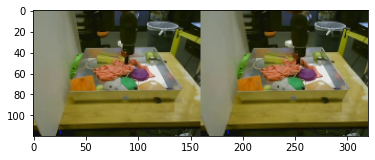


timestep 4 is good
timestep 5
[ 0.58575556  0.5018383  -0.06146258  2.62287429] current state
[ 0.59339145  0.54701416 -0.04570589  2.86749433] next state
[0.0076359  0.04517586 0.01575669 0.24462003] true state diff
[ 0.013122   -0.01411013  0.03013617 -0.01468513] raw action
[0.0054861  0.059286   0.01437948 0.25930517] error between raw action and true state diff


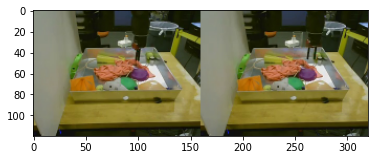


timestep 6
[ 0.59339145  0.54701416 -0.04570589  2.86749433] current state
[ 0.66756625  0.59040791 -0.09920942  3.31087127] next state
[ 0.0741748   0.04339375 -0.05350353  0.44337694] true state diff
[0.02219411 0.02005694 0.08100582 0.17235015] raw action
[0.05198069 0.02333681 0.13450935 0.27102679] error between raw action and true state diff


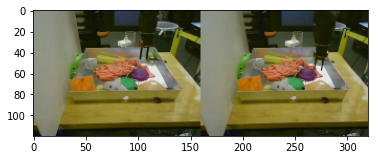


timestep 7 is good
timestep 8
[ 0.70629286  0.58936307 -0.14811024  3.52064678] current state
[ 0.73836741  0.58181884 -0.14984034  3.61412514] next state
[ 0.03207455 -0.00754423 -0.00173011  0.09347836] true state diff
[0.0556001  0.05883102 0.12203041 0.0381288 ] raw action
[0.02352555 0.06637526 0.12376052 0.05534957] error between raw action and true state diff


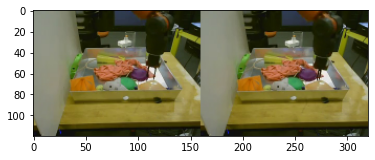


timestep 9 is good
timestep 10 is good
timestep 11 is good
timestep 12 is good
timestep 13 is good
timestep 14 is good
timestep 15
[ 0.75170133  0.58789223 -0.04896085  3.86859921] current state
[ 0.74640247  0.58275613 -0.10480768  3.86200946] next state
[-0.00529886 -0.0051361  -0.05584683 -0.00658974] true state diff
[0.05393575 0.01046978 0.13719661 0.19131436] raw action
[0.05923461 0.01560588 0.19304344 0.19790411] error between raw action and true state diff


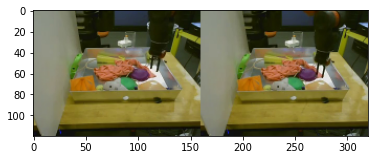


timestep 16
[ 0.74640247  0.58275613 -0.10480768  3.86200946] current state
[ 0.74873579  0.59241785 -0.12704131  3.8528403 ] next state
[ 0.00233332  0.00966173 -0.02223363 -0.00916916] true state diff
[ 0.09370242  0.03301566 -0.11048112  0.11484325] raw action
[0.0913691  0.02335393 0.08824749 0.12401241] error between raw action and true state diff


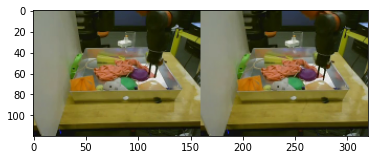


timestep 17 is good
timestep 18 is good
timestep 19 is good
timestep 20 is good
timestep 21 is good
timestep 22
[ 0.67640164  0.58665896 -0.15183485  4.95408986] current state
[ 0.68115801  0.58718346 -0.15128597  5.01713913] next state
[0.00475637 0.0005245  0.00054888 0.06304927] true state diff
[-0.06779422  0.00221716 -0.03599858 -0.01702155] raw action
[0.07255059 0.00169266 0.03654746 0.08007082] error between raw action and true state diff


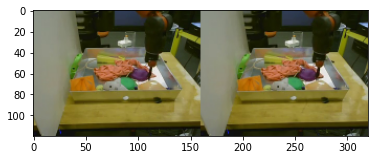


timestep 23
[ 0.68115801  0.58718346 -0.15128597  5.01713913] current state
[ 0.71977592  0.5843927  -0.15024452  4.82391954] next state
[ 0.03861791 -0.00279076  0.00104144 -0.19321959] true state diff
[-0.09665011  0.04069286 -0.12519194  0.17300786] raw action
[0.13526802 0.04348361 0.12623339 0.36622745] error between raw action and true state diff


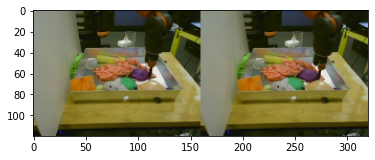


timestep 24 is good
timestep 25
[ 0.7393127   0.5857782  -0.14846663  5.00529426] current state
[ 0.75885078  0.58505148 -0.14819267  5.09309243] next state
[ 0.01953808 -0.00072672  0.00027396  0.08779817] true state diff
[ 0.02421216  0.05206592  0.01741179 -0.04689252] raw action
[0.00467407 0.05279264 0.01713783 0.13469069] error between raw action and true state diff


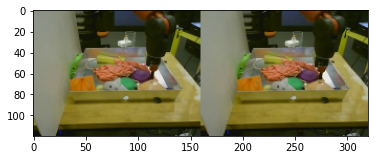


timestep 26
[ 0.75885078  0.58505148 -0.14819267  5.09309243] current state
[ 0.72610361  0.58563031 -0.11317723  5.07438557] next state
[-0.03274717  0.00057883  0.03501544 -0.01870686] true state diff
[ 0.01291402  0.09171621 -0.06981787 -0.13566417] raw action
[0.04566119 0.09113737 0.10483331 0.11695731] error between raw action and true state diff


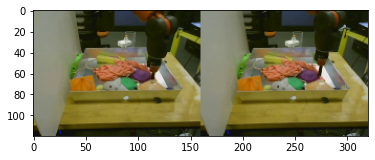


timestep 27
[ 0.72610361  0.58563031 -0.11317723  5.07438557] current state
[ 0.66788092  0.58445996 -0.04685699  5.13527436] next state
[-0.05822269 -0.00117036  0.06632024  0.06088879] true state diff
[ 0.0031832   0.03589862  0.01042176 -0.10077225] raw action
[0.06140589 0.03706898 0.05589848 0.16166104] error between raw action and true state diff


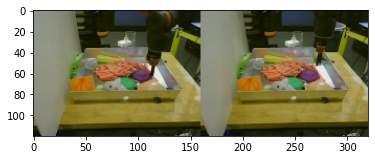


timestep 28
[ 0.66788092  0.58445996 -0.04685699  5.13527436] current state
[ 0.60754886  0.58841117 -0.05008594  5.53775321] next state
[-0.06033206  0.00395121 -0.00322895  0.40247885] true state diff
[ 0.00078441  0.01150603 -0.08881642  0.15947867] raw action
[0.06111647 0.00755482 0.08558747 0.24300017] error between raw action and true state diff


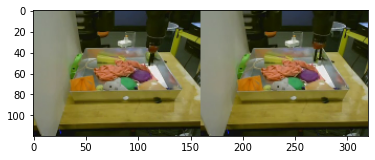


timestep 29 is good


In [172]:
error_threshold = 0.05
for t, ac in enumerate(actions):
    state = states[t]        
    next_state = states[t+1]
    true_state_diff = next_state - state
    error = np.abs(true_state_diff[:4] - ac[:4])
    if np.any(error[:2] > error_threshold):
    
        print("timestep", t)
        print(state[:4], "current state")
        print(next_state[:4], "next state")
        print(true_state_diff[:4], "true state diff")
        print(ac[:4], "raw action")
        print(error, "error between raw action and true state diff")
        img = np.concatenate([imgs[t], imgs[t+1]], axis=1)
        plt.imshow(img)
        plt.show()
        print()
    else:
        print("timestep", t, "is good")



Check the Sawyer

In [214]:
traj_name = sawyer_subset.index[0]
df.loc[traj_name]["policy_desc"]

'random policy, gaussian noise: std_xy=0.035, std_z=0.08, std_theta=pi/18, autograsp for gripper'

In [215]:
file_name = os.path.join(robonet_root, traj_name)
file_metadata = sawyer_subset.loc[traj_name]
with h5py.File(file_name, "r") as f:
    imgs = load_camera_imgs(0, f, file_metadata, hparams.img_size)


In [216]:
states = robot_data["sawyer"][0]
low = robot_min["sawyer"][:3]
high = robot_max["sawyer"][:3]
states = states[:, :4].copy()
states[:, :3] = (states[:, :3] * (high - low)) + low

actions = action_data["sawyer"][0]
print("low", low)
print("high", high)

low [ 0.45  -0.18   0.176]
high [0.79  0.22  0.292]


timestep 0 is bad
[ 0.55242664 -0.02010936  0.20426691  2.72576992] current state
[ 0.56936618 -0.06335259  0.19029172  3.15589564] next state
[ 0.01693954 -0.04324323 -0.01397519  0.43012572] true state diff
[-0.0130661   0.01367971 -0.0983028   0.01281009] raw action
[0.03000564 0.05692294 0.08432761 0.41731562] error between raw action and true state diff
[False False  True] [False False  True]


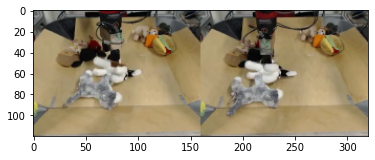


timestep 1 is bad
[ 0.56936618 -0.06335259  0.19029172  3.15589564] current state
[0.58470786 0.00677737 0.23277197 3.3560423 ] next state
[0.01534168 0.07012996 0.04248025 0.20014667] true state diff
[ 0.01493694 -0.00457313 -0.10161141 -0.32391478] raw action
[0.00040474 0.07470308 0.14409166 0.52406145] error between raw action and true state diff
[False False  True] [False False False]


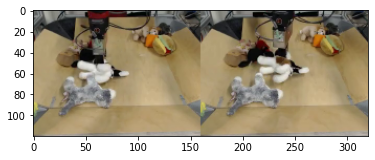


timestep 2 is bad
[0.58470786 0.00677737 0.23277197 3.3560423 ] current state
[0.64785581 0.00138954 0.2779707  3.63555205] next state
[ 0.06314795 -0.00538782  0.04519874  0.27950974] true state diff
[ 0.01433802  0.05038391 -0.20017978  0.27896205] raw action
[0.04880994 0.05577173 0.24537851 0.00054769] error between raw action and true state diff
[False False False] [False False  True]


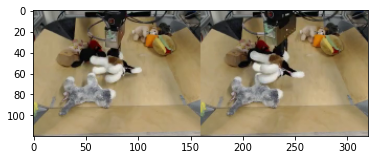


timestep 3 is bad
[0.64785581 0.00138954 0.2779707  3.63555205] current state
[ 0.71550675 -0.01951736  0.19719406  3.66750915] next state
[ 0.06765094 -0.0209069  -0.08077664  0.0319571 ] true state diff
[-0.00147241  0.00344028 -0.10753295  0.04547159] raw action
[0.06912335 0.02434718 0.02675631 0.01351449] error between raw action and true state diff
[False False  True] [False False  True]


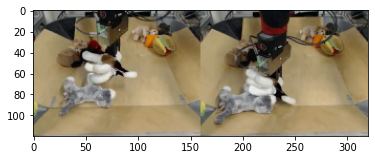


timestep 4 is bad
[ 0.71550675 -0.01951736  0.19719406  3.66750915] current state
[ 0.68585473 -0.0239038   0.19169592  3.69791138] next state
[-0.02965202 -0.00438644 -0.00549814  0.03040223] true state diff
[-0.04022779  0.0531281   0.01007687 -0.2107119 ] raw action
[0.01057577 0.05751454 0.01557501 0.24111413] error between raw action and true state diff
[False False  True] [False False  True]


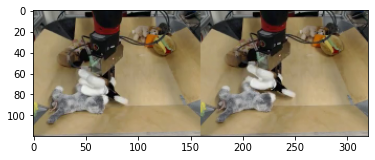


timestep 5 is bad
[ 0.68585473 -0.0239038   0.19169592  3.69791138] current state
[ 0.63920695 -0.0553719   0.22449498  3.94586518] next state
[-0.04664778 -0.0314681   0.03279906  0.2479538 ] true state diff
[-0.00244998  0.00935059 -0.01398873 -0.0805896 ] raw action
[0.0441978  0.04081869 0.04678779 0.3285434 ] error between raw action and true state diff
[False False  True] [False False False]


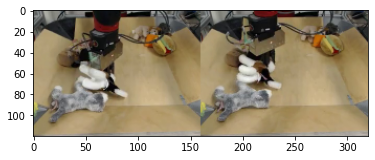


timestep 6 is bad
[ 0.63920695 -0.0553719   0.22449498  3.94586518] current state
[ 0.59768131 -0.07987371  0.1916141   3.94407203] next state
[-0.04152563 -0.02450181 -0.03288088 -0.00179315] true state diff
[ 0.02265615  0.01815452 -0.0416141   0.44047928] raw action
[0.06418179 0.04265633 0.00873321 0.44227243] error between raw action and true state diff
[False False False] [False False  True]


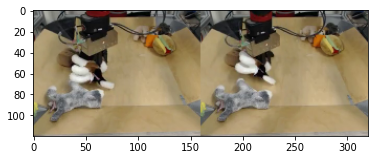


timestep 7 is good
[ 0.59768131 -0.07987371  0.1916141   3.94407203] current state
[ 0.59415069 -0.06179744  0.24605064  3.72051877] next state
[-0.00353062  0.01807627  0.05443655 -0.22355327] true state diff
[-0.0007248   0.01012268 -0.00836011  0.31372909] raw action
[0.00280583 0.00795359 0.06279665 0.53728235] error between raw action and true state diff
[False False  True] [False False False]


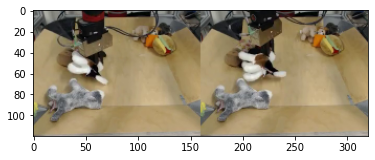


timestep 8 is bad
[ 0.59415069 -0.06179744  0.24605064  3.72051877] current state
[ 0.59961514 -0.00476715  0.27535575  3.4105053 ] next state
[ 0.00546445  0.0570303   0.02930511 -0.31001346] true state diff
[-0.00421134 -0.02085112 -0.1221493  -0.03124288] raw action
[0.00967579 0.07788142 0.15145441 0.27877058] error between raw action and true state diff
[False False False] [False False  True]


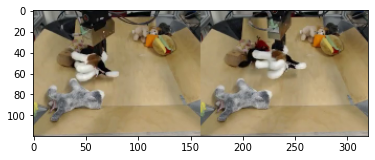


timestep 9 is bad
[ 0.59961514 -0.00476715  0.27535575  3.4105053 ] current state
[0.63706889 0.03647998 0.25203395 3.45055639] next state
[ 0.03745375  0.04124713 -0.0233218   0.04005108] true state diff
[ 0.01122136 -0.03064278  0.04097379 -0.15257209] raw action
[0.02623239 0.0718899  0.06429559 0.19262317] error between raw action and true state diff
[False False  True] [False False False]


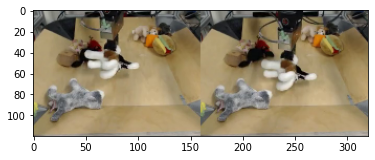


timestep 10 is bad
[0.63706889 0.03647998 0.25203395 3.45055639] current state
[0.62056046 0.00343669 0.28128085 3.38882718] next state
[-0.01650844 -0.03304329  0.0292469  -0.0617292 ] true state diff
[-0.00447211  0.0164467  -0.03292011 -0.46584205] raw action
[0.01203633 0.04948999 0.06216701 0.40411284] error between raw action and true state diff
[False False False] [False False  True]


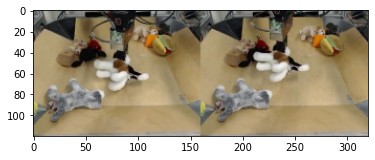


timestep 11 is bad
[0.62056046 0.00343669 0.28128085 3.38882718] current state
[ 0.66986107 -0.02653358  0.29418427  3.39091561] next state
[ 0.04930061 -0.02997027  0.01290342  0.00208842] true state diff
[ 0.0001263   0.00581119  0.14421855 -0.01053786] raw action
[0.04917431 0.03578146 0.13131513 0.01262628] error between raw action and true state diff
[False False  True] [False False  True]


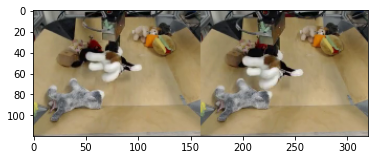


timestep 12 is bad
[ 0.66986107 -0.02653358  0.29418427  3.39091561] current state
[ 0.65508023 -0.04368896  0.22405785  3.80240012] next state
[-0.01478084 -0.01715538 -0.07012642  0.41148451] true state diff
[-0.05188521 -0.06081201 -0.01316949  0.22756873] raw action
[0.03710437 0.04365663 0.05695693 0.18391578] error between raw action and true state diff
[False False  True] [False False False]


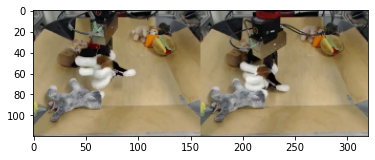


timestep 13 is bad
[ 0.65508023 -0.04368896  0.22405785  3.80240012] current state
[ 0.68198574 -0.10896342  0.25939879  3.9909237 ] next state
[ 0.02690551 -0.06527446  0.03534094  0.18852358] true state diff
[-0.03955229  0.02119557 -0.02022639 -0.41012825] raw action
[0.06645781 0.08647003 0.05556733 0.59865183] error between raw action and true state diff
[False False False] [False False False]


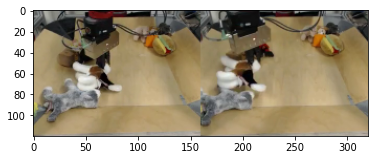


timestep 14 is bad
[ 0.68198574 -0.10896342  0.25939879  3.9909237 ] current state
[ 0.70430951 -0.11638629  0.27354489  4.14875769] next state
[ 0.02232377 -0.00742288  0.0141461   0.15783399] true state diff
[-0.01760875 -0.03343814 -0.02995264  0.15391808] raw action
[0.03993252 0.02601526 0.04409874 0.00391592] error between raw action and true state diff
[False False False] [False False  True]


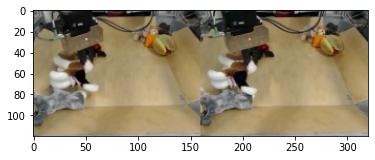


timestep 15 is bad
[ 0.70430951 -0.11638629  0.27354489  4.14875769] current state
[ 0.6912558  -0.11821874  0.19171666  3.90432926] next state
[-0.01305371 -0.00183244 -0.08182823 -0.24442843] true state diff
[ 0.03140942 -0.0028225   0.10411344 -0.0350781 ] raw action
[0.04446313 0.00099005 0.18594168 0.20935033] error between raw action and true state diff
[False False  True] [False False  True]


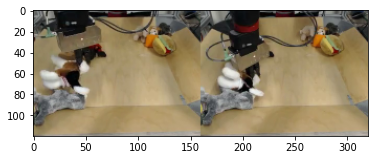


timestep 16 is bad
[ 0.6912558  -0.11821874  0.19171666  3.90432926] current state
[ 0.66690419 -0.15855127  0.19188063  3.68051929] next state
[-0.02435161 -0.04033254  0.00016397 -0.22380997] true state diff
[-0.04008662  0.01024057  0.0258488   0.12870513] raw action
[0.01573501 0.05057311 0.02568482 0.3525151 ] error between raw action and true state diff
[False False  True] [False  True  True]


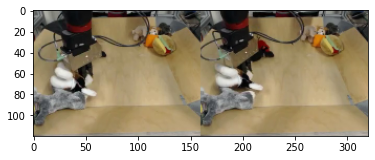


timestep 17 is bad
[ 0.66690419 -0.15855127  0.19188063  3.68051929] current state
[ 0.73782611 -0.17919118  0.29194399  3.48343736] next state
[ 0.07092192 -0.02063991  0.10006336 -0.19708193] true state diff
[ 0.0625686   0.02852371 -0.07796898 -0.13303242] raw action
[0.00835332 0.04916362 0.17803234 0.0640495 ] error between raw action and true state diff
[False  True  True] [False  True  True]


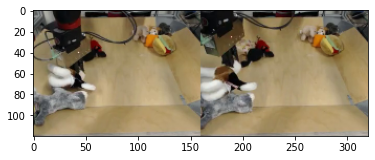


timestep 18 is bad
[ 0.73782611 -0.17919118  0.29194399  3.48343736] current state
[ 0.70885128 -0.16383953  0.28483475  3.43243273] next state
[-0.02897483  0.01535166 -0.00710924 -0.05100463] true state diff
[ 0.02020504 -0.0086345  -0.0780964  -0.05446048] raw action
[0.04917987 0.02398616 0.07098716 0.00345585] error between raw action and true state diff
[False  True  True] [False  True  True]


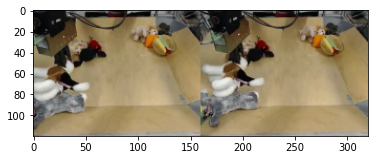


timestep 19 is bad
[ 0.70885128 -0.16383953  0.28483475  3.43243273] current state
[ 0.71441411 -0.17976647  0.24498042  3.8868715 ] next state
[ 0.00556283 -0.01592695 -0.03985432  0.45443877] true state diff
[-0.01813324 -0.01410445 -0.00658657  0.17849716] raw action
[0.02369607 0.00182249 0.03326776 0.2759416 ] error between raw action and true state diff
[False  True  True] [False  True False]


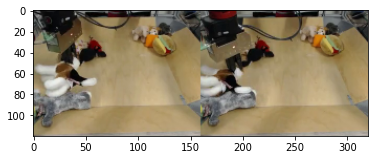


timestep 20 is bad
[ 0.71441411 -0.17976647  0.24498042  3.8868715 ] current state
[ 0.69981531 -0.14963658  0.23066332  3.9123802 ] next state
[-0.0145988   0.03012989 -0.0143171   0.0255087 ] true state diff
[ 0.06876105 -0.06513228 -0.07373616 -0.04647652] raw action
[0.08335985 0.09526217 0.05941906 0.07198522] error between raw action and true state diff
[False  True False] [False False False]


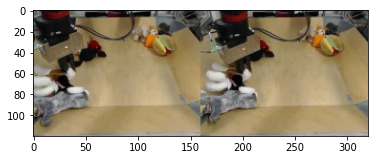


timestep 21 is bad
[ 0.69981531 -0.14963658  0.23066332  3.9123802 ] current state
[ 0.69627431 -0.18017256  0.2090774   3.82997275] next state
[-0.003541   -0.03053598 -0.02158592 -0.08240745] true state diff
[-0.01873763 -0.00372358 -0.08299098  0.18431446] raw action
[0.01519663 0.02681239 0.06140507 0.2667219 ] error between raw action and true state diff
[False False False] [False  True False]


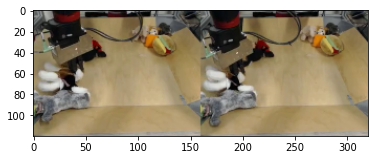


timestep 22 is good
[ 0.69627431 -0.18017256  0.2090774   3.82997275] current state
[ 0.72788092 -0.17053587  0.23011751  3.58874514] next state
[ 0.03160661  0.00963669  0.02104011 -0.24122761] true state diff
[0.03381468 0.02297131 0.030883   0.10484395] raw action
[0.00220808 0.01333462 0.00984289 0.34607156] error between raw action and true state diff
[False  True False] [False  True False]


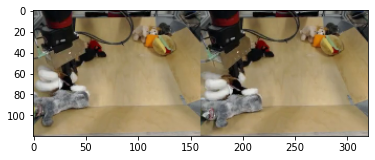


timestep 23 is good
[ 0.72788092 -0.17053587  0.23011751  3.58874514] current state
[ 0.76499685 -0.18032145  0.19217913  3.78856876] next state
[ 0.03711593 -0.00978558 -0.03793838  0.19982362] true state diff
[ 0.03073371 -0.00392132  0.03166876  0.08089113] raw action
[0.00638223 0.00586426 0.06960714 0.11893249] error between raw action and true state diff
[False  True False] [ True  True  True]


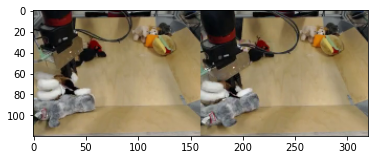


timestep 24 is bad
[ 0.76499685 -0.18032145  0.19217913  3.78856876] current state
[ 0.76536535 -0.16978914  0.19187027  3.59183676] next state
[ 0.0003685   0.01053232 -0.00030886 -0.196732  ] true state diff
[ 0.03225573  0.02716351 -0.05538106 -0.10996527] raw action
[0.03188723 0.0166312  0.0550722  0.08676673] error between raw action and true state diff
[ True  True  True] [ True  True  True]


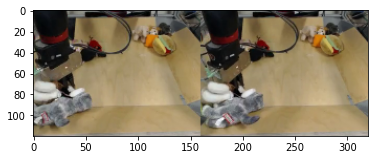


timestep 25 is bad
[ 0.76536535 -0.16978914  0.19187027  3.59183676] current state
[ 0.75570349 -0.18019762  0.19643246  3.47624536] next state
[-0.00966186 -0.01040848  0.00456219 -0.1155914 ] true state diff
[ 0.05340923  0.0061799   0.0007339  -0.13888278] raw action
[0.06307109 0.01658838 0.0038283  0.02329138] error between raw action and true state diff
[ True  True  True] [False  True  True]


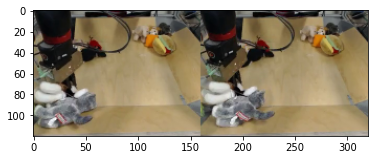


timestep 26 is bad
[ 0.75570349 -0.18019762  0.19643246  3.47624536] current state
[ 0.77064154 -0.15394088  0.20441295  3.54737797] next state
[0.01493804 0.02625674 0.00798048 0.07113261] true state diff
[ 0.01780284 -0.05440806 -0.06811712  0.14106812] raw action
[0.0028648  0.0806648  0.0760976  0.06993552] error between raw action and true state diff
[False  True  True] [ True  True  True]


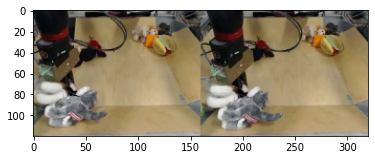


timestep 27 is bad
[ 0.77064154 -0.15394088  0.20441295  3.54737797] current state
[ 0.72697966 -0.18025602  0.29738914  3.59174623] next state
[-0.04366187 -0.02631515  0.09297619  0.04436826] true state diff
[-0.06896723 -0.01084378 -0.08988052 -0.30885278] raw action
[0.02530536 0.01547136 0.18285671 0.35322103] error between raw action and true state diff
[ True  True  True] [False  True  True]


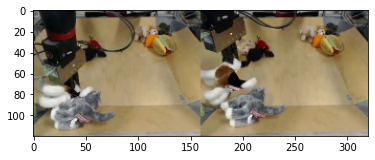


timestep 28 is bad
[ 0.72697966 -0.18025602  0.29738914  3.59174623] current state
[ 0.72913734 -0.17973915  0.29469295  3.65800229] next state
[ 0.00215767  0.00051687 -0.00269619  0.06625606] true state diff
[-0.01522164 -0.03641044  0.05343386  0.17886723] raw action
[0.01737932 0.03692731 0.05613005 0.11261117] error between raw action and true state diff
[False  True  True] [False  True  True]


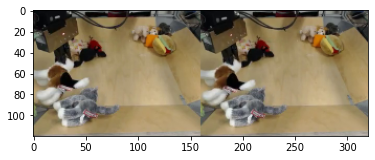


timestep 29 is bad
[ 0.72913734 -0.17973915  0.29469295  3.65800229] current state
[ 0.73178615 -0.17934761  0.29380659  3.62148124] next state
[ 0.00264881  0.00039154 -0.00088636 -0.03652105] true state diff
[-0.00249523 -0.04358026  0.02107655  0.07886004] raw action
[0.00514405 0.0439718  0.02196292 0.11538109] error between raw action and true state diff
[False  True  True] [False  True  True]


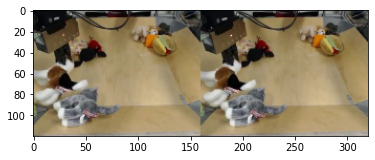

In [217]:
error_threshold = 0.03
for t, ac in enumerate(actions):
    state = states[t]        
    next_state = states[t+1]
    true_state_diff = next_state - state
    error = np.abs(true_state_diff[:4] - ac[:4])
    good = "good" if np.all(error[:3] < error_threshold) else "bad"
    if good:
        
    print("timestep", t, "is", good)
    print(state[:4], "current state")
    print(next_state[:4], "next state")
    print(true_state_diff[:4], "true state diff")
    print(ac[:4], "raw action")
    print(error, "error between raw action and true state diff")
    # check if states are near boundaries
    state_dist = np.minimum(np.abs(state[:3] - low), np.abs(state[:3] - high))
    next_state_dist = np.minimum(np.abs(next_state[:3] - low), np.abs(next_state[:3] - high))
    state_close = state_dist < 0.03 # within 3cm of the boundary
    next_state_close = next_state_dist < 0.03
    print(state_close, next_state_close)

    img = np.concatenate([imgs[t], imgs[t+1]], axis=1)
    plt.imshow(img)
    plt.show()
    print()




Visualize action distribution of the robot

sawyer Raw Data stats
-1.0 1.0


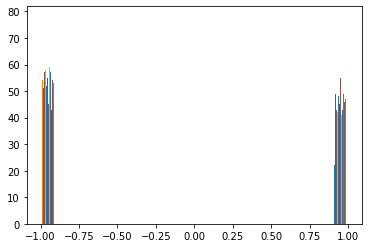

In [11]:
for robot, actions in action_data.items():
    axis = 4
    ac = actions[:, :,  axis]
    print(f"{robot} Raw Data stats")
    print(np.min(ac), np.max(ac))
    plt.hist(ac, bins=[0.1 * x for x in range(-10, 11)])
    plt.show()

baxter_left Raw Data stats
-0.1138357685466248 0.09542590781582427


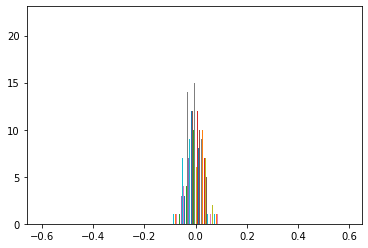

baxter_right Raw Data stats
-0.09662275512448214 0.09380308025389485


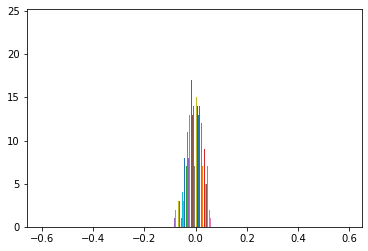

sawyer Raw Data stats
-0.07 0.07


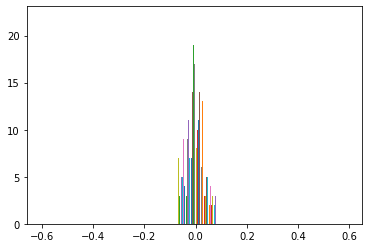

widowx Raw Data stats
-0.07 0.07


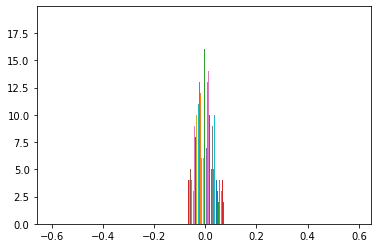

In [201]:
for robot, actions in action_data.items():
    axis = 0
    ac = actions[:, :,  axis]
    print(f"{robot} Raw Data stats")
    print(np.min(ac), np.max(ac))
    plt.hist(ac, bins=[0.01 * x for x in range(-60, 60)])
    plt.show()

baxter_left Raw Data stats
-0.09398274956270351 0.1030899031629213


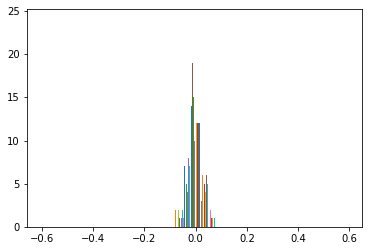

baxter_right Raw Data stats
-0.0966929567240147 0.10715482840765476


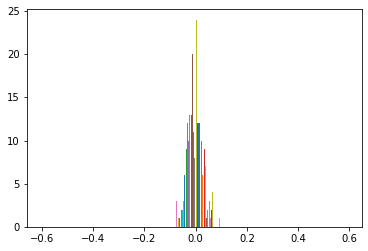

sawyer Raw Data stats
-0.07 0.07


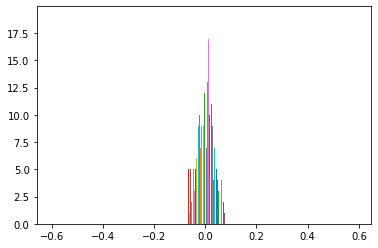

widowx Raw Data stats
-0.07 0.07


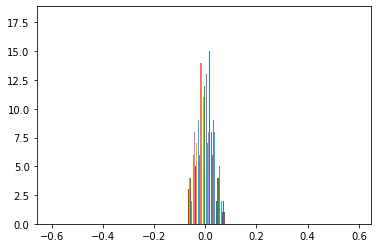

In [202]:
for robot, actions in action_data.items():
    axis = 1
    ac = actions[:, :,  axis]
    print(f"{robot} Raw Data stats")
    print(np.min(ac), np.max(ac))
    plt.hist(ac, bins=[0.01 * x for x in range(-60, 60)])
    plt.show()

In [11]:
traj_name = widowx_subset.index[0]
df.loc[traj_name]["policy_desc"]
file_name = os.path.join(robonet_root, traj_name)
file_metadata = widowx_subset.loc[traj_name]
with h5py.File(file_name, "r") as f:
    imgs = load_camera_imgs(0, f, file_metadata, hparams.img_size)
states = robot_data["widowx"][0]
low = robot_min["widowx"][:3]
high = robot_max["widowx"][:3]
states = states[:, :4].copy()
states[:, :3] = (states[:, :3] * (high - low)) + low

actions = action_data["widowx"][0]
print("low", low)
print("high", high)

low [-0.13 -0.13  0.35]
high [0.13 0.13 0.45]


In [6]:
error_threshold = 0.015
for t, ac in enumerate(actions):
    state = states[t]        
    next_state = states[t+1]
    true_state_diff = next_state - state
    error = np.abs(true_state_diff[:4] - ac[:4])
    good = "good" if np.all(error[:2] < error_threshold) else "bad"

    print("timestep", t, "is", good)
    print(state[:4], "current state")
    print(next_state[:4], "next state")
    print(true_state_diff[:4], "true state diff")
    print(ac[:4], "raw action")
    print(error, "error between raw action and true state diff")
    # check if states are near boundaries
    state_dist = np.minimum(np.abs(state[:3] - low), np.abs(state[:3] - high))
    next_state_dist = np.minimum(np.abs(next_state[:3] - low), np.abs(next_state[:3] - high))
    state_close = state_dist < 0.03 # within 3cm of the boundary
    next_state_close = next_state_dist < 0.03
    print(state_close, next_state_close)

    img = np.concatenate([imgs[t], imgs[t+1]], axis=1)
    plt.imshow(img)
    plt.show()
    print()




NameError: name 'actions' is not defined

In [12]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook 
errors = np.zeros((len(actions),3))
error_threshold = 0.03
for t, ac in enumerate(actions):
    state = states[t]        
    next_state = states[t+1]
    true_state_diff = next_state - state
    error = np.abs(true_state_diff[:4] - ac[:4])
    errors[t] = error[:3]
#     good = "good" if np.all(error[:3] < error_threshold) else "bad"
#     if good:
        
#     print("timestep", t, "is", good)
#     print(state[:4], "current state")
#     print(next_state[:4], "next state")
#     print(true_state_diff[:4], "true state diff")
#     print(ac[:4], "raw action")
#     print(error, "error between raw action and true state diff")
#     # check if states are near boundaries
#     state_dist = np.minimum(np.abs(state[:3] - low), np.abs(state[:3] - high))
#     next_state_dist = np.minimum(np.abs(next_state[:3] - low), np.abs(next_state[:3] - high))
#     state_close = state_dist < 0.03 # within 3cm of the boundary
#     next_state_close = next_state_dist < 0.03
#     print(state_close, next_state_close)

#     img = np.concatenate([imgs[t], imgs[t+1]], axis=1)
#     plt.imshow(img)
#     plt.show()
#     print()




In [13]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


<IPython.core.display.Javascript object>


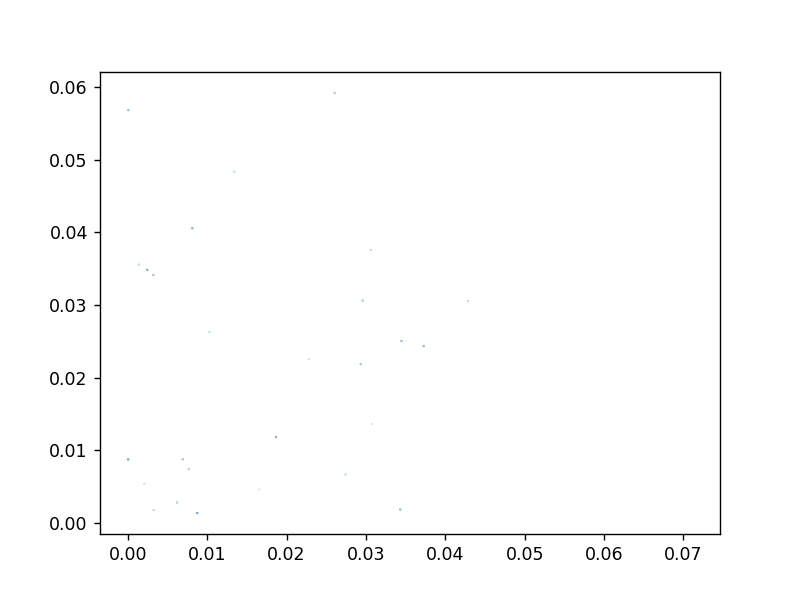

In [15]:
plt.scatter(errors[:, 0], errors[:, 1], errors[:, 2])
# plt.show()